# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

# Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [1]:
# Подключение библиотек

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.tree import DecisionTreeClassifier # дерево решений
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.dummy import DummyClassifier # для проверки модели на адекватность

from sklearn.model_selection import train_test_split, GridSearchCV # для разделения выборки и поиска по сетке наил. параметров

# метрики
from sklearn.metrics import accuracy_score

# настройки
warnings.filterwarnings('ignore')
%matplotlib inline

### Откроем файл с данными и изучим его

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# Общая информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df[['calls', 'minutes', 'messages', 'mb_used']].describe()

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836
std,33.236368,234.569872,36.148326,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500
50%,62.000000,430.600000,30.000000,16943.235000
75%,82.000000,571.927500,57.000000,21424.700000
max,244.000000,1632.060000,224.000000,49745.730000


In [6]:
df.duplicated().sum()

0

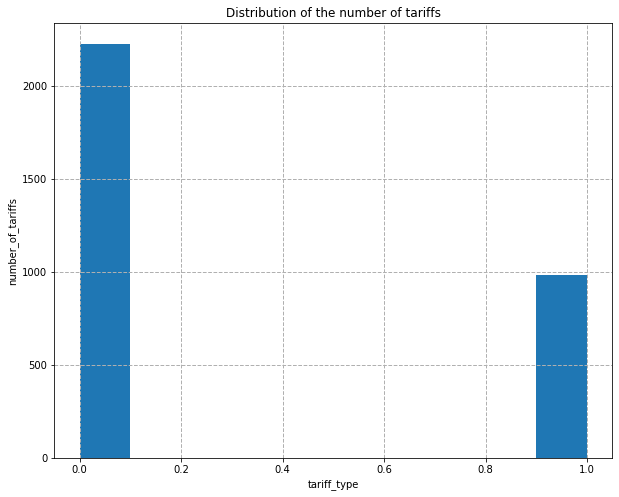

In [7]:
# Построим гистограмму для целевого признака, чтобы посмотреть на сбалансированность данных в нём

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(10)  
fig.set_figheight(8)

ax.hist(df['is_ultra'])

ax.grid(linewidth = 1,   
        linestyle = '--')

# добавляем название графика
ax.set(title='Distribution of the number of tariffs')

# добавляем подписи к осям:
ax.set_xlabel('tariff_type')
ax.set_ylabel('number_of_tariffs')

plt.show()

In [8]:
df['is_ultra'].value_counts()

is_ultra
0    2229
1     985
Name: count, dtype: int64

Количество строк и столбцов таблицы: 3214 и 5, соответственно. Пропусков нет, явные дубликаты отсутствуют, все признаки подходящих типов. Можно наблюдать некую несбалансированность классов, так как около 31% данных относится к тарифу «Ультра», а  остальные 69% - к тарифу «Смарт».

In [9]:
# почти 1, значит есть сильная, положительная, линейная зависимость

df['calls'].corr(df['minutes']).round(2)

0.98

#### Вывод:
Наблюдается мультиколлинеарность и дисбаланс. Нулей у нас 69% это значит для того, чтобы наша модель была адекватной, её метрика должна быть выше 0,69. Можно побороться с мультиколлинеарностью, в том случае, если мы захотим посмотреть как конкретно признаки влияют на целевой.

### Разделим исходные данные на обучающую, валидационную и тестовую выборки

Многие модели машинного обучения имеют параметры, которые влияют на то, каким образом обучается модель. В таких случаях мы используем тренировочную выборку чтобы обучить модель, валидационную чтобы проверить её качество и, если нужно, подправить параметры каким-то образом. Наконец, тестовую выборку мы используем лишь для окончательной проверки качества модели.

Целевым значением для нас будет значение `is_ultra` (показатель тарифа, которым пользовался условный пользователь в течение месяца). Вынесем этот столбец в отдельную переменную y, а в переменную X запишем все столбцы из таблицы df кроме целевого столбца:

In [10]:
# Сохраним признаки и целевой признак (далее ц.п.) в отдельных переменных
# Введём обозначения: X - признаки, y - ц.п. (по аналогии с обозначениями выборок)

X = df.drop(columns='is_ultra') # извлекаем признаки

y = df['is_ultra'] # извлекаем целевой признак

In [11]:
# X, y

Разобьём наши данные на тренировочную, валидационную и тестовую выборки, в соотношении 60/20/20:

In [12]:
X_train, X_test_aux, y_train, y_test_aux = train_test_split(X, y, 
                                                            test_size=0.4, 
                                                            random_state=239, 
                                                            stratify=y)

In [13]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test_aux, y_test_aux, 
                                                    test_size=0.5, 
                                                    random_state=239, 
                                                    stratify=y_test_aux)

In [14]:
# Проверка

X_train.shape, X_valid.shape, X_test.shape
y_train.shape, y_valid.shape, y_test.shape

((1928,), (643,), (643,))

Далее работаем с тренировочными `X_train`, `y_train`, валидационными `X_valid`, `y_valid` и тестовыми (на этапе финальной оценки качества модели) `X_test`, `y_test` выборками.

### Исследуем качество разных моделей, меняя гиперпараметры

In [15]:
# Функция для вывода значений метрик для построенных моделей

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('ACCURACY\n')
    print('Metric value on test data:\t' + str(round(accuracy_score(test_true_values, test_pred_values), 4)))
    print('Metric value on training data:\t' + str(round(accuracy_score(train_true_values, train_pred_values), 4)))

#### Для решения задачи классификации используем `логистическую регрессию`

In [16]:
#?LogisticRegression

Построим простую модель с типом оптимизатора `liblinear`. Посмотрим на метрики модели при изменении параметров, отвечающих за тип регуляризации (L1 или L2), и параметра `max_iter`, который задаёт максимальное количество итераций обучения. Найдём значения данных гиперпараметров, соответствующие лучшему значению `accuracy`:

In [17]:
%%time

best_model = None
best_result = 0
best_parameters = []

for i, penalty in enumerate(['l1', 'l2']):
    
    for iter_count in range(100, 500):
        
        lr_model = LogisticRegression(random_state=239, solver='liblinear', penalty=penalty, max_iter=iter_count)
        lr_model.fit(X_train, y_train)
        
        y_valid_pred = lr_model.predict(X_valid) 
        
        result = accuracy_score(y_valid, y_valid_pred)
        
        if result > best_result:
            best_model = lr_model
            best_result = result
            best_parameters.extend([penalty, iter_count])
                    
print('Best model accuracy:', best_result.round(4))
print('Parameters of the best model', best_parameters)

Best model accuracy: 0.7294
Parameters of the best model ['l1', 100]
CPU times: total: 3.39 s
Wall time: 3.39 s


Для модели логистической регрессии с настройками вида:

- `random_state = 239`, 
- `solver = liblinear`, 
- `penalty = l1`, 
- `max_iter = 100` 

получено лучшее значение метрики (на валидационной выборке), равное `0.7294`. Найдём точность на тренировочной выборке, чтобы оценить возможное переобучение.

In [18]:
y_train_pred = best_model.predict(X_train)

print('Best model accuracy:', round(accuracy_score(y_train, y_train_pred), 4))

Best model accuracy: 0.7526


Точность на тренировочной и валидационной выборках примерно одинаковая (если точность на тренировочной выборке оказывается сильно выше, то это означает переобучение модели).

Попробуем изменить тип оптимизатора, возьмём `lbfgs`:

In [19]:
lr_model_2 = LogisticRegression(random_state=239, solver='lbfgs', max_iter=500) # построение модели

lr_model_2.fit(X_train, y_train); # обучение модели

In [20]:
y_train_pred = lr_model_2.predict(X_train)
y_valid_pred = lr_model_2.predict(X_valid) 

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

ACCURACY

Metric value on test data:	0.7325
Metric value on training data:	0.7521


#### Вывод: 
В качестве лучшей модели логистической регрессии стоит зафиксировать модель `lr_model_2`, с соответствующими настройками гиперпараметров (`random_state = 239`, `solver = lbfgs`, `max_iter = 500`). Значение метрики качества (`accuracy`) для данной модели составляет `0.7325`.    

#### Для решения задачи классификации используем `дерево решений`

In [21]:
#?DecisionTreeClassifier

In [22]:
dtc_model = DecisionTreeClassifier(random_state=239, max_depth=3) # построение модели

dtc_model.fit(X_train, y_train); # обучение модели

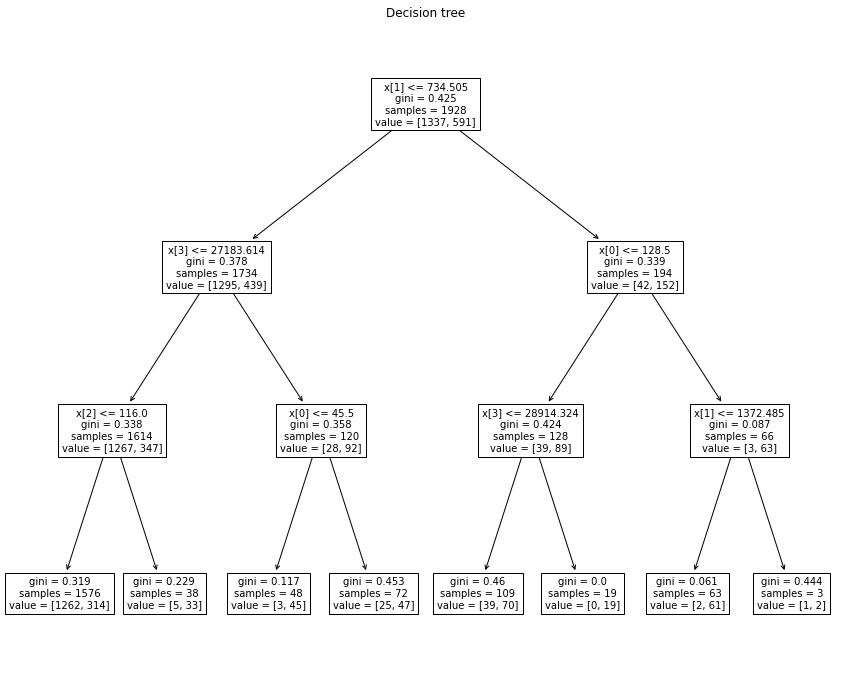

In [23]:
# Визуализация дерева решений для построенной модели    

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12)

tree.plot_tree(dtc_model, fontsize=10, ax=ax);

# добавляем название графика
ax.set(title='Decision tree')

plt.show()

In [24]:
# Получаем предсказания

y_train_pred = dtc_model.predict(X_train)
y_valid_pred = dtc_model.predict(X_valid) 

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

ACCURACY

Metric value on test data:	0.7776
Metric value on training data:	0.7982


Похоже на то, что модель склонна переобучаться с увеличением значения `max_depth` (макс. глубина дерева). Построим модель для различных значений глубины `max_depth`, чтобы подобрать наиболее оптимальное:

In [25]:
%%time

depth_values = np.arange(1, 21)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(depth_values):
    dtc = DecisionTreeClassifier(random_state=239, max_depth=value)
    
    dtc.fit(X_train, y_train)
    
    y_pred_valid = dtc.predict(X_valid)
    y_pred_train = dtc.predict(X_train)
        
    if i % 2 != 0:
        print(f'max_depth = {value}')
        print(f'\taccuracy_valid = {round(accuracy_score(y_valid, y_pred_valid), 4)}')
        print(f'\taccuracy_train = {round(accuracy_score(y_train, y_pred_train), 4)}\n')
            
    accuracy_on_valid.append(accuracy_score(y_valid, y_pred_valid))
    accuracy_on_train.append(accuracy_score(y_train, y_pred_train))

max_depth = 2
	accuracy_valid = 0.7698
	accuracy_train = 0.7837

max_depth = 4
	accuracy_valid = 0.7776
	accuracy_train = 0.7993

max_depth = 6
	accuracy_valid = 0.7916
	accuracy_train = 0.8262

max_depth = 8
	accuracy_valid = 0.7698
	accuracy_train = 0.8496

max_depth = 10
	accuracy_valid = 0.7807
	accuracy_train = 0.8797

max_depth = 12
	accuracy_valid = 0.7729
	accuracy_train = 0.9035

max_depth = 14
	accuracy_valid = 0.7558
	accuracy_train = 0.9372

max_depth = 16
	accuracy_valid = 0.7496
	accuracy_train = 0.9632

max_depth = 18
	accuracy_valid = 0.7341
	accuracy_train = 0.985

max_depth = 20
	accuracy_valid = 0.7481
	accuracy_train = 0.9959

CPU times: total: 234 ms
Wall time: 214 ms


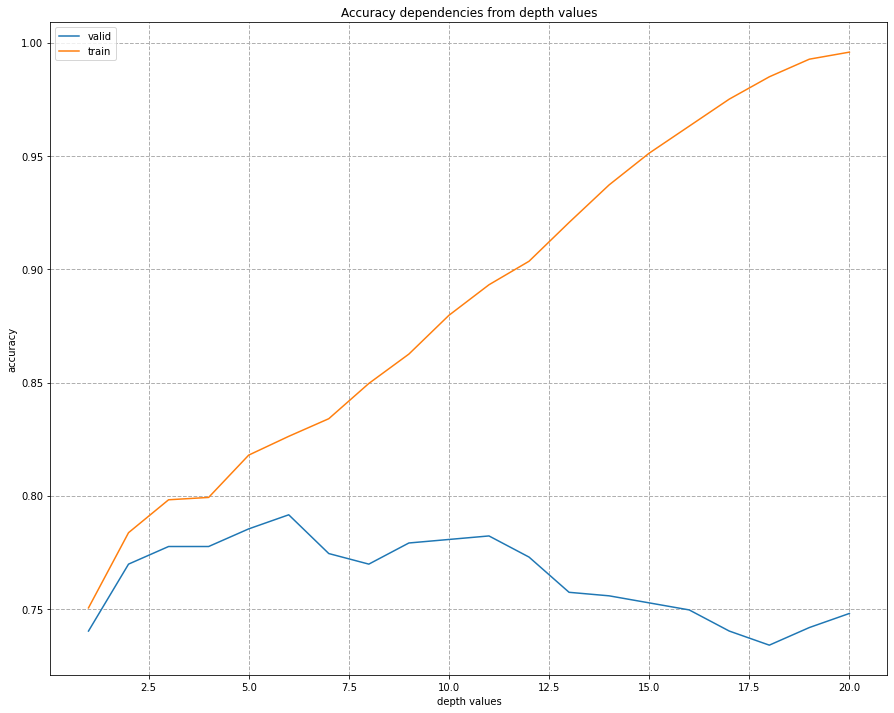

In [26]:
# Строим графики зависимости accuracy на тренир. и валидац. выборках от значений глубины  

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12)

ax.plot(depth_values, accuracy_on_valid, label='valid')
ax.plot(depth_values, accuracy_on_train, label='train')

ax.legend()
ax.grid(linewidth = 1,   
        linestyle = '--')

# добавляем название графика
ax.set(title='Accuracy dependencies from depth values')

# добавляем подписи к осям:
ax.set_xlabel('depth values')
ax.set_ylabel('accuracy')

plt.show()

При достаточно больших значениях параметра max_depth точность на тренировочных данных стремиться к 1 (склонность к переобучению). На валидационных данных точность достигает своего максимума при `max_depth` = 6, а затем начинает падать.

Построим модель по полученной информации, зафиксируем её как лучшую:

In [27]:
dtc_model = DecisionTreeClassifier(random_state=239, max_depth=6) # построение модели

dtc_model.fit(X_train, y_train); # обучение модели

In [28]:
# Получаем предсказания

y_train_pred = dtc_model.predict(X_train)
y_valid_pred = dtc_model.predict(X_valid) 

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

ACCURACY

Metric value on test data:	0.7916
Metric value on training data:	0.8262


#### Вывод:
В качестве лучшей модели дерева решений берём модель `dtc_model`, с соответствующими настройками гиперпараметров. Значение метрики качества (`accuracy`) для данной модели составляет `0.7916`.

#### Для решения задачи классификации используем `случайный лес`

In [29]:
#?RandomForestClassifier

In [30]:
rfc_model = RandomForestClassifier(random_state=239) # построение модели

rfc_model.fit(X_train, y_train); # обучение модели

In [31]:
# Получаем предсказания

y_train_pred = rfc_model.predict(X_train)
y_valid_pred = rfc_model.predict(X_valid) 

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

ACCURACY

Metric value on test data:	0.79
Metric value on training data:	1.0


Попробуем попдобрать наилучшие параметры, такие как `n_estimators` - число деревьев в ансамбле и `max_depth` - максимальная глубина дерева, воспользовавшись поиском по сетке. Зададим сетку необходимых нам параметров:

In [32]:
parameters = {
    'n_estimators': [10, 50, 100, 150, 200], 
    'max_depth': np.arange(5, 11)
}

gs_clf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=239), 
            param_grid=parameters, 
            scoring='accuracy', 
            cv=5
)

Для обучения GridSearch разделим исходные данные только на тренировочную и тестовую выборки (валидационную выборку выделять не будем):

In [33]:
# Делим данные на тренировочные и тестовые

features_train, features_test, target_train, target_test = train_test_split(X, y, 
                                                                            test_size=0.25, 
                                                                            random_state=239, 
                                                                            stratify=y)

In [34]:
%%time

gs_clf.fit(features_train, target_train); # обучаем GS на тренир. данных

CPU times: total: 46.6 s
Wall time: 46.6 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=239),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10]),
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='accuracy')

In [35]:
# Посмотрим на результаты

gs_results = pd.DataFrame(gs_clf.cv_results_)
gs_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [36]:
# Посмотрим как зависит значение метрики от выбранных параметров

param_columns = [column for column in gs_results.columns if column.startswith('param_')]
score_columns = ['mean_test_score']

gs_results = gs_results[param_columns + score_columns].sort_values(by=score_columns, ascending=False)
gs_results.head()

,param_max_depth,param_n_estimators,mean_test_score
21,9,50,0.817842
22,9,100,0.817427
23,9,150,0.817012
24,9,200,0.815353
28,10,150,0.815353


In [37]:
# Наилучшие параметры модели

gs_clf.best_params_

{'max_depth': 9, 'n_estimators': 50}

In [38]:
# Значение метрики 

round(gs_clf.best_score_, 4)

0.8178

In [39]:
# Получена модель с наилучшими параметрами, сохраним её в переменную rfc_model

rfc_model = gs_clf.best_estimator_

In [40]:
# Получаем предсказания

y_train_pred = rfc_model.predict(X_train)
y_valid_pred = rfc_model.predict(X_valid) 

evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

ACCURACY

Metric value on test data:	0.8274
Metric value on training data:	0.874


#### Вывод:
В качестве лучшей модели случайного леса берём модель `rfc_model`, с соответствующими настройками гиперпараметров. Значение метрики качества (`accuracy`) для данной модели составляет `0.8274`.

### Проверим качество модели на тестовой выборке

В процессе исследования лучший результат, соотв. наибольшему значению метрики качества, показала модель случайного леса, с настройками гиперпараметров:

- `random_state` = 239,

- `max_depth` = 9, 

- `n_estimators` = 50. 

Проверим качество данной модели на тестовых данных:

In [41]:
%%time

final_model = RandomForestClassifier(random_state=239, max_depth=9, n_estimators=50) # построение модели

final_model.fit(X_train, y_train); # обучение модели

CPU times: total: 188 ms
Wall time: 191 ms


RandomForestClassifier(max_depth=9, n_estimators=50, random_state=239)

In [42]:
# Получаем предсказания

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test) 

evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

ACCURACY

Metric value on test data:	0.8383
Metric value on training data:	0.8766


### Проверим модели на адекватность

Один из способов проверки модели на адекватность - сравнение с базовой моделью, которая предсказывает одно и то же значение. В качестве базовой модели рассмотрим `DummyClassifier`, со стратегией `most_frequent` (предсказание наиболее частым классом), сравним точности на базовой и нашей лучшей модели: 

In [43]:
dc_model = DummyClassifier(random_state=239, strategy='most_frequent') # построение модели

dc_model.fit(X_train, y_train); # обучение модели

In [44]:
# Получаем предсказания

y_train_pred = dc_model.predict(X_train)
y_test_pred = dc_model.predict(X_test) 

evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

ACCURACY

Metric value on test data:	0.6936
Metric value on training data:	0.6935


Для базовой модели на тестовых данных получено значение метрики, равное `0.6936`, против `0.8383` нашей лучшей модели. Можно сделать вывод об адекватности построенной модели (точность превосходит точность базовой модели). 

#### Вывод:
В процессе исследования были апробированы такие модели машинного обучения, как: логистическая регрессия, решающее дерево и случайный лес. После настройки некоторых гиперпараметров, наилучший результат в плане точности показала модель случайного леса (`accuracy = 0.8178` на валидационной выборке). При проверке работы данной модели на тестовых данных получено значение `accuracy`, равное `0.8383`, что превосходит установленный порог в `0.75`. 

Использовать полученный результат в бизнесе возможно, например, таким образом: допустим какой-то тариф более выгоден компании, тогда мы можем предложить перейти на него клиентам, но не всем, а тем, кому данный тариф подходит (на основе прогноза модели). Мы сэкономим время и деньги, ведь просто предлагать переходить всем это лишние траты (не говоря о клиентах, которые уходят, если слишком назойливо им что-то предлагать, что для них явно не подходит).